In [ ]:
###### DATA EXTRACTION ######

In [1]:
import pandas as pd
import numpy as np
import ast
import glob
import re

# Define the list of files and their corresponding city names
file_city_mapping = {
    'bangalore_cars.xlsx': 'Bangalore',
    'chennai_cars.xlsx': 'Chennai',
    'delhi_cars.xlsx': 'Delhi',
    'hyderabad_cars.xlsx': 'Hyderabad',
    'jaipur_cars.xlsx': 'Jaipur',
    'kolkata_cars.xlsx': 'Kolkata'
}

# Initialize an empty list to store processed DataFrames
all_data = []

for file_name, city in file_city_mapping.items():
    # Load data from the current Excel file
    try:
        data = pd.read_excel(file_name)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping...")
        continue

    # Initialize empty lists for each column
    ft = []
    bt = []
    kilometers_driven = []
    transmission = []
    no_of_owners = []
    owner = []
    oem = []
    model = []
    model_year = []
    central_variant_id = []
    variant_name = []
    price = []
    registration_year = []
    insurance_validity = []
    rto = []
    engine_cc = []
    seats = []
    mileage = []

    # Loop through each row in the DataFrame
    for i in range(data.shape[0]):
        try:
            # Convert the string representation of dictionaries to actual dictionaries
            new_car_detail = ast.literal_eval(data['new_car_detail'][i])
            new_car_overview = ast.literal_eval(data['new_car_overview'][i])
            new_car_feature = ast.literal_eval(data['new_car_feature'][i])
            new_car_specs = ast.literal_eval(data['new_car_specs'][i])
        except (ValueError, SyntaxError):
            print(f"Skipping row {i} in file {file_name} due to parsing error")
            continue

        # Extract data from dictionaries (same logic as before)
        ft.append(new_car_detail.get('ft', None))
        bt.append(new_car_detail.get('bt', None))
        kilometers_driven.append(new_car_detail.get('km', None))
        transmission.append(new_car_detail.get('transmission', None))
        no_of_owners.append(new_car_detail.get('ownerNo', None))
        oem.append(new_car_detail.get('oem', None))
        model.append(new_car_detail.get('model', None))
        model_year.append(int(new_car_detail.get('modelYear', 0)))  # Default to 0
        central_variant_id.append(int(new_car_detail.get('centralVariantId', 0)))
        variant_name.append(new_car_detail.get('variantName', None))
        try:
            price.append(float(new_car_detail['price'][2:-5]) * 100000)
        except (KeyError, ValueError):
            price.append(None)

        # Handle registration year, insurance validity, and other columns
        try:
            registration_year.append(new_car_overview['top'][0]['value'][-4:])
        except (IndexError, KeyError):
            registration_year.append(None)

        try:
            insurance_validity.append(new_car_overview['top'][1]['value'])
        except (IndexError, KeyError):
            insurance_validity.append(None)

        # Handle RTO and other
        rto_value = None
        for item in new_car_overview.get('top', []):
            if item.get('key') == 'RTO':
                rto_value = item.get('value')
        rto.append(rto_value)

        # Handle seats, engine_cc, and mileage
        mileage_value = None
        engine_cc_value = None
        seats_value = None
        for item in new_car_specs.get('top', []):
            if item.get('key') == 'Mileage':
                match = re.search(r'\d+\.\d+|\d+', item.get('value', ''))
                mileage_value = match.group() if match else None  # Extracts "23.84" correctly

            if item.get('key') == 'Engine':
                match = re.search(r'\d+', item.get('value', ''))
                engine_cc_value = match.group() if match else None  # Extracts "1197" from "1197 CC"

            if item.get('key') == 'Seats':
                seats_value = ''.join(filter(str.isdigit, item.get('value', '')))  # Extract only digits

        mileage.append(mileage_value)
        engine_cc.append(engine_cc_value)
        seats.append(seats_value)

    # Add lists as columns to the DataFrame
    data['City'] = city  # Add city column
    data['ft'] = ft
    data['bt'] = bt
    data['Transmission'] = transmission
    data['No_of_Owners'] = no_of_owners
    data['Car_Model'] = model
    data['Model_Year'] = model_year
    data['Car_Price'] = price
    data['Insurance Validity'] = insurance_validity
    data['Mileage(kmpl)'] = mileage

    # Drop unnecessary columns
    data = data.drop(['new_car_detail', 'new_car_overview', 'new_car_feature', 'new_car_specs','car_links'], axis=1)

    # Append the processed DataFrame to the list
    all_data.append(data)

# Concatenate all datasets
final_data = pd.concat(all_data, ignore_index=True)

# Export the processed data to a single CSV file
output_file = 'all_cities_cars_data.csv'
final_data.to_csv(output_file, index=False)

print(f"Processed data for all cities has been saved to {output_file}")


Processed data for all cities has been saved to all_cities_cars_data.csv


In [ ]:
###### DATA PROCESSING ######

In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load the dataset
input_file = 'all_cities_cars_data.csv'
data = pd.read_csv(input_file)

# Checking duplicate rows
print(f"Duplicate rows before dropping: {data.duplicated().sum()}")

# Drop duplicate rows
data.drop_duplicates(inplace=True)

# Handling missing values
print(f"Missing values before handling: {data.isnull().sum()}")

# Categorical Columns - Mode Imputation or 'Unknown'
categorical_columns = ['ft', 'bt', 'Transmission', 'Car_Model']
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode()[0] if data[col].mode().dropna().size > 0 else 'Unknown')

# Columns where missing values are replaced with 'Unknown'
unknown_fill_columns = ['Insurance Validity']
for col in unknown_fill_columns:
    data[col] = data[col].fillna('Unknown')

# Numerical Columns - Mean/Median Imputation
numerical_impute_median = ['Model_Year']
numerical_impute_mean = ['Car_Price', 'Mileage(kmpl)']

for col in numerical_impute_median:
    data[col] = data[col].fillna(data[col].median())

for col in numerical_impute_mean:
    data[col] = data[col].fillna(data[col].mean())

# Special Case
data['No_of_Owners'] = data['No_of_Owners'].fillna(1)

# Function to clean and convert numerical columns
def clean_numeric_column(column):
    return pd.to_numeric(column.astype(str).str.replace(',', '').str.replace(' kms', ''), errors='coerce')

# Clean and convert numeric columns
numerical_columns = ['Car_Price', 'Mileage(kmpl)']
for col in numerical_columns:
    if col in data.columns:
        data[col] = clean_numeric_column(data[col])

# ------- FEATURE ENGINEERING -------
# Create new features
# 1. Brand Extraction from Car Model
data['Brand'] = data['Car_Model'].astype(str).apply(lambda x: x.split()[0])

# 2. Mileage Category (Binning)
data['Mileage_Category'] = pd.qcut(data['Mileage(kmpl)'], q=3, labels=['Low', 'Medium', 'High'])

# Encoding Categorical Variables
# Label Encoding for ordinal + high cardinality nominal columns
label_encode_cols = ['ft', 'bt', 'Brand', 'Car_Model', 'Insurance Validity', 'City', 'Mileage_Category']

label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# One-Hot Encoding for low cardinality columns
data = pd.get_dummies(data, columns=['Transmission'], drop_first=True)

# Save the column names (after one-hot encoding) for future use in Streamlit app
joblib.dump(data.columns, "model_columns.pkl")  # Save columns to be used later in Streamlit

data['Transmission_Manual'] = data['Transmission_Manual'].astype(int)

# Remove Outliers (IQR Method)
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

outlier_columns = ['Car_Price', 'Mileage(kmpl)']
for col in outlier_columns:
    data = remove_outliers(data, col)

# Normalize Numerical Features
scaler = MinMaxScaler()
scale_columns = ['Mileage(kmpl)']
data[scale_columns] = scaler.fit_transform(data[scale_columns])

# Save encoders and scaler for future use (important for Streamlit)
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'minmax_scaler.pkl')

# Export cleaned data
output_file = 'processed_all_cars_data.csv'
data.to_csv(output_file, index=False)

print(f"Processed and cleaned data has been saved to {output_file}")


Duplicate rows before dropping: 202
Missing values before handling: City                    0
ft                      0
bt                      4
Transmission            0
No_of_Owners            0
Car_Model               0
Model_Year              0
Car_Price               0
Insurance Validity      0
Mileage(kmpl)         280
dtype: int64
Processed and cleaned data has been saved to processed_all_cars_data.csv


In [ ]:
###### EDA ANALYSIS ######

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7155 entries, 0 to 7154
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   City                 7155 non-null   int64  
 1   ft                   7155 non-null   int64  
 2   bt                   7155 non-null   int64  
 3   No_of_Owners         7155 non-null   int64  
 4   Car_Model            7155 non-null   int64  
 5   Model_Year           7155 non-null   int64  
 6   Car_Price            7155 non-null   float64
 7   Insurance Validity   7155 non-null   int64  
 8   Mileage(kmpl)        7155 non-null   float64
 9   Brand                7155 non-null   int64  
 10  Mileage_Category     7155 non-null   int64  
 11  Transmission_Manual  7155 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 670.9 KB
None
   City  ft  bt  No_of_Owners  Car_Model  Model_Year  Car_Price  \
0     0   4   2             3        160        2015   400000.0   
1

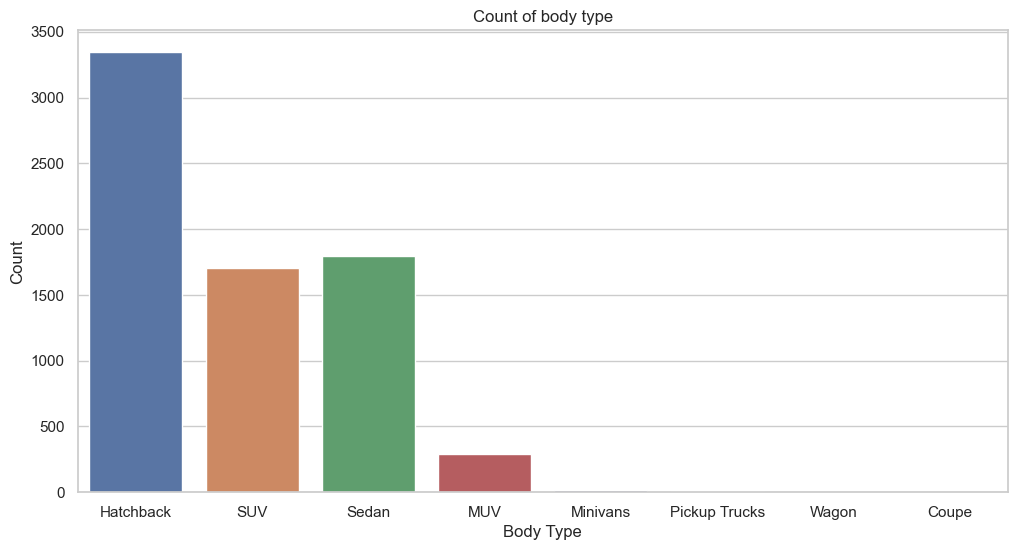

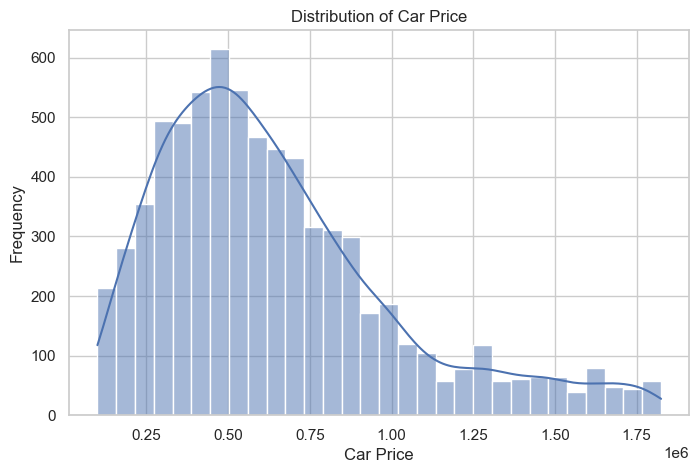

C:\Users\Admin\AppData\Local\Temp\ipykernel_10648\2651929946.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


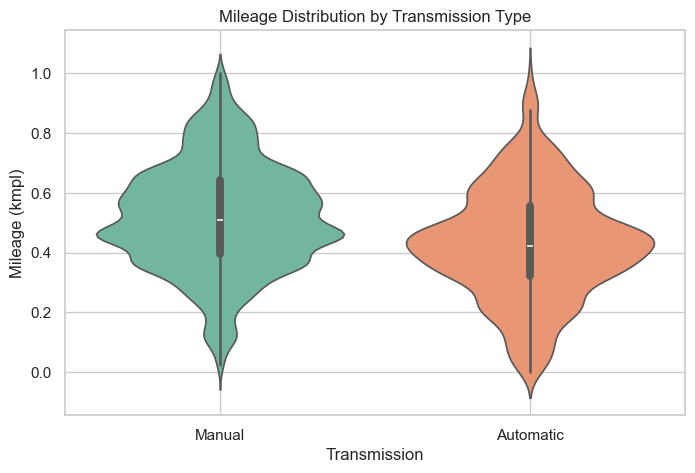

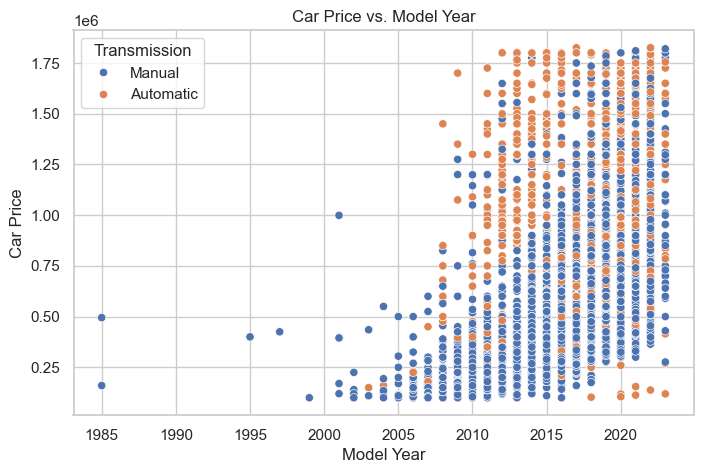

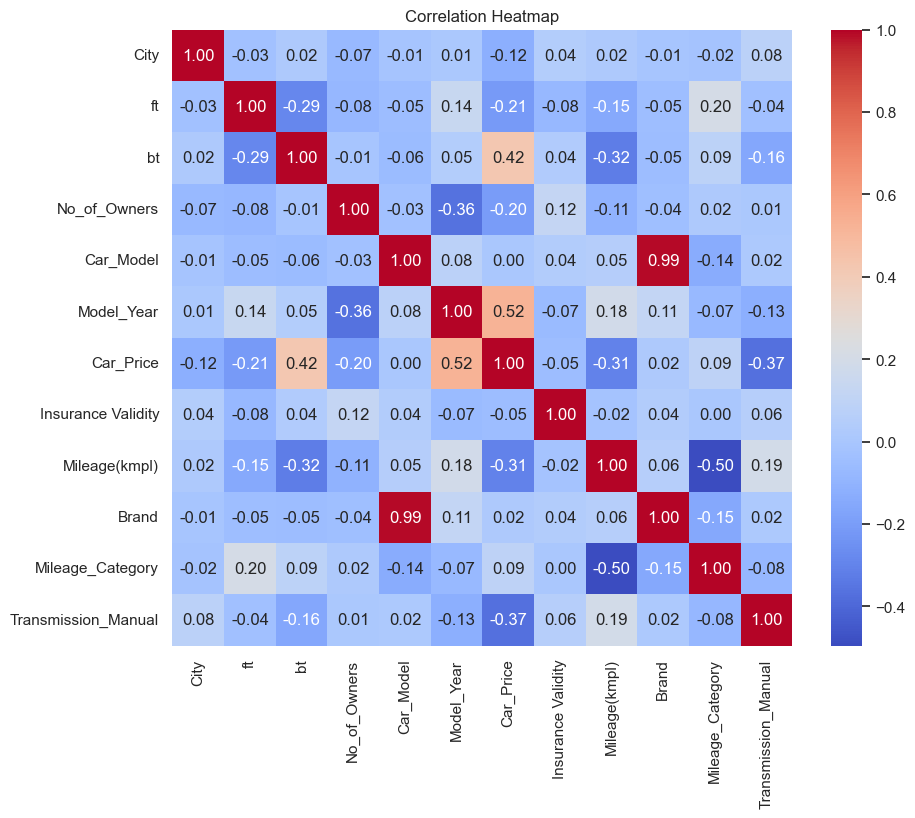


Visualizations generated successfully!

--- Correlation with Car_Price ---
Car_Price              1.000000
Model_Year             0.523441
bt                     0.424672
Mileage_Category       0.094682
Brand                  0.021952
Car_Model              0.004859
Insurance Validity    -0.052894
City                  -0.121989
No_of_Owners          -0.203848
ft                    -0.209171
Mileage(kmpl)         -0.306290
Transmission_Manual   -0.367425
Name: Car_Price, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_10648\2651929946.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation.values, y=correlation.index, palette="viridis")


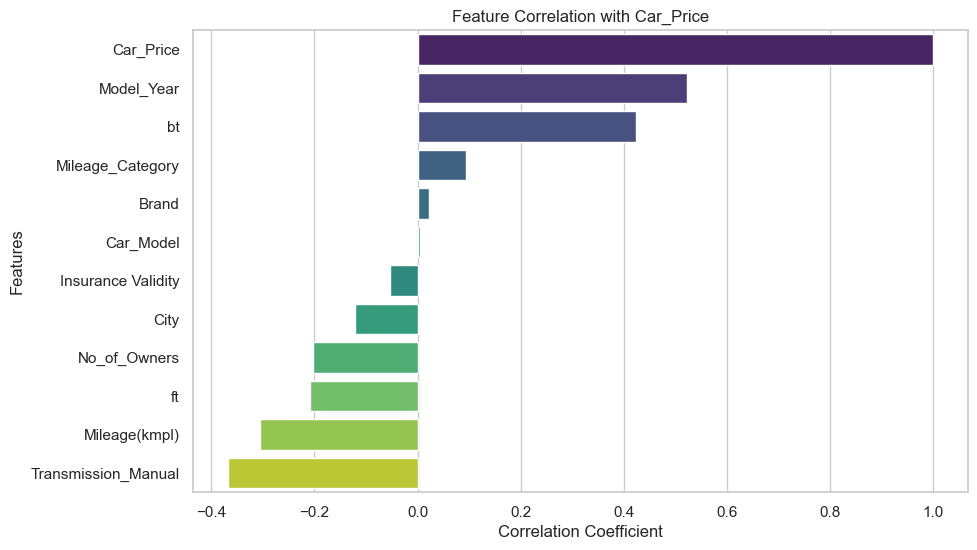


--- Feature Importance from Random Forest ---
Model_Year             0.289187
bt                     0.283589
Mileage(kmpl)          0.120716
Car_Model              0.090594
Transmission_Manual    0.071196
Brand                  0.041705
City                   0.039882
ft                     0.037488
Insurance Validity     0.011374
No_of_Owners           0.010087
Mileage_Category       0.004181
dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_10648\2651929946.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_sorted.values, y=importances_sorted.index, palette='mako')


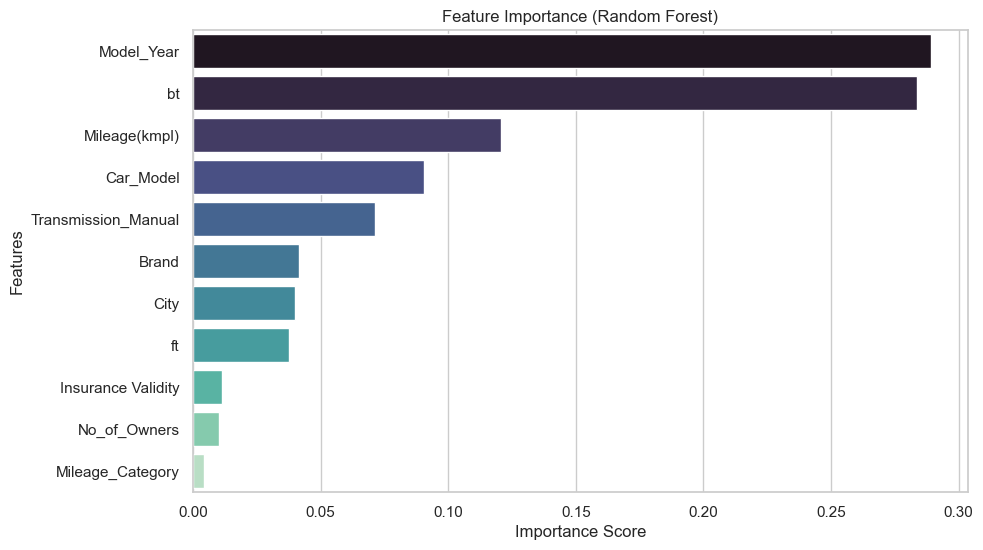


EDA is completed successfully !!


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed data
data = pd.read_csv('processed_all_cars_data.csv')

# Basic Info
print(data.info())
print(data.head())

# ---------------------------------------------------------------------------------------------------
# DESCRIPTIVE STATISTICS SECTION
# ---------------------------------------------------------------------------------------------------

print("\n--- Summary Statistics ---")
print(data.describe(include='all'))

# Calculation
# Median
print("Median:\n", data.median(numeric_only=True))

# Mode (can return multiple modes)
print("Mode:\n", data.mode(numeric_only=True).iloc[0])

# Variance
print("Variance:\n", data.var(numeric_only=True))

# Standard Deviation
print("Standard Deviation:\n", data.std(numeric_only=True))

# Skewness
print("Skewness:\n", data.skew(numeric_only=True))

# Kurtosis
print("Kurtosis:\n", data.kurt(numeric_only=True))

# Number of entries in each category
categorical_columns = ['City', 'ft', 'bt', 'Transmission_Manual', 'Car_Model', 'Mileage_Category', 'Brand', 'Insurance Validity']
# (True=Manual, False=Automatic)

for col in categorical_columns:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts())

# Check for unique values and data types
print(data.dtypes)
print("\nUnique values per column:")
print(data.nunique())

print("\nDescriptive Statistics completed successfully")


# ----------------------------------------------------------------------------------------------------
# DATA VISUALIZATION SECTION
# ----------------------------------------------------------------------------------------------------

# Set Seaborn style
sns.set(style="whitegrid")

# 1. Countplot - Count of body type
import joblib

# Load label encoders
label_encoders = joblib.load('label_encoders.pkl')

# Decode the body type labels
data['bt_name'] = label_encoders['bt'].inverse_transform(data['bt'])

plt.figure(figsize=(12,6))
plt.title("Count of body type")
sns.countplot(x='bt_name', data=data, hue='bt_name')
plt.xlabel('Body Type')
plt.ylabel('Count')
plt.show()

# 2. Histogram - Distribution of Car Price
plt.figure(figsize=(8, 5))
sns.histplot(data['Car_Price'], bins=30, kde=True)  # Kernel Density Estimate
plt.title('Distribution of Car Price')
plt.xlabel('Car Price')
plt.ylabel('Frequency')    # Frequency = number of cars priced within each price range (bin)
plt.show()

# 3. Violin Plot - Mileage by Transmission Type
plt.figure(figsize=(8, 5))
sns.violinplot(
    x=data['Transmission_Manual'].map({1: 'Manual', 0: 'Automatic'}),
    y=data['Mileage(kmpl)'], 
    data=data, inner='box', palette='Set2')
plt.title('Mileage Distribution by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Mileage (kmpl)')
plt.grid(True)
plt.show()

# 4. Scatter plot: Car Price vs Model Year
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Model_Year', y='Car_Price',
                hue=data['Transmission_Manual'].map({1: 'Manual', 0: 'Automatic'}),
                data=data)
plt.title('Car Price vs. Model Year')
plt.xlabel('Model Year')
plt.ylabel('Car Price')
plt.legend(title='Transmission')
plt.grid(True)
plt.show()

# 5. Correlation Heatmap - Between Numerical Features
plt.figure(figsize=(10, 8))
corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Success message
print("\nVisualizations generated successfully!")


# ----------------------------------------------------------------------------------------------------
# FEATURE SELECTION SECTION
# ----------------------------------------------------------------------------------------------------

# Correlation Analysis
# Correlation with Car_Price
correlation = data.corr(numeric_only=True)['Car_Price'].sort_values(ascending=False)
print("\n--- Correlation with Car_Price ---")
print(correlation)

# Visualize top correlated features
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation.values, y=correlation.index, palette="viridis")
plt.title('Feature Correlation with Car_Price')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Feature Importance using Tree-based Model (Random Forest)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# Drop target from features
X = data.drop('Car_Price', axis=1)
y = data['Car_Price']

# Use only numeric and encoded features
X = X.select_dtypes(include=[np.number])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

# Display
print("\n--- Feature Importance from Random Forest ---")
print(importances_sorted)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_sorted.values, y=importances_sorted.index, palette='mako')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

print("\nEDA is completed successfully !!")


In [ ]:
###### MODEL DEVELOPMENT ######

In [4]:
# ------ TRAIN TEST SPLIT ------
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

data = pd.read_csv('processed_all_cars_data.csv')

# Features (X) and Target (y)
X = data.drop('Car_Price', axis=1)
y = data['Car_Price']

# If needed, select only numeric features
X = X.select_dtypes(include=[np.number])

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


# ------ MODEL SELECTION -------
# 1] Linear Regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize and train
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
lr_preds = lr_model.predict(X_test)

# Evaluate
lr_r2 = r2_score(y_test, lr_preds)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_mse = mean_squared_error(y_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)

print("1] Linear Regression:")
print(f"R² Score: {lr_r2:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"MSE: {lr_mse:.2f}")
print(f"RMSE: {lr_rmse:.2f}")

# 2] Decision Tree

from sklearn.tree import DecisionTreeRegressor

# Create and train the model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on test data
dt_preds = dt_model.predict(X_test)

# Evaluate the model with formatted output
r2 = r2_score(y_test, dt_preds)
mae = mean_absolute_error(y_test, dt_preds)
mse = mean_squared_error(y_test, dt_preds)
rmse = np.sqrt(mse)

print("\n2] Decision Tree:")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# 3] Random Forest

from sklearn.ensemble import RandomForestRegressor

# Create and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
rf_preds = rf_model.predict(X_test)

# Evaluate the model with formatted output
r2 = r2_score(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)
mse = mean_squared_error(y_test, rf_preds)
rmse = np.sqrt(mse)

print("\n3] Random Forest:")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

# 4] Gradient Boosting

from sklearn.ensemble import GradientBoostingRegressor

# Create and train the model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on test data
gb_preds = gb_model.predict(X_test)

# Evaluate the model with formatted output
r2 = r2_score(y_test, gb_preds)
mae = mean_absolute_error(y_test, gb_preds)
mse = mean_squared_error(y_test, gb_preds)
rmse = np.sqrt(mse)

print("\n4] Gradient Boosting:")
print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


# ------ MODEL TRAINING / CROSS VALIDATION ------
from sklearn.model_selection import cross_val_score

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

cv_results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    avg_score = scores.mean()
    cv_results.append({'Model': name, 'CV Scores': scores, 'Average R²': avg_score})
    print(f"\n{name} Cross-Validation R² Scores: {scores}")
    print(f"{name} Average R² Score: {avg_score:.2f}") 

# Convert to DataFrame (Optional)
cv_df = pd.DataFrame(cv_results)
print("\nCross-Validation Summary:")
print(cv_df[['Model', 'Average R²']])


Train shape: (5724, 11)
Test shape: (1431, 11)
1] Linear Regression:
R² Score: 0.65
MAE: 155594.36
MSE: 45285266287.47
RMSE: 212803.35

2] Decision Tree:
R² Score: 0.74
MAE: 108206.63
MSE: 33052305192.76
RMSE: 181802.93

3] Random Forest:
R² Score: 0.86
MAE: 81931.30
MSE: 18505108572.57
RMSE: 136033.48

4] Gradient Boosting:
R² Score: 0.81
MAE: 103811.67
MSE: 23675840746.29
RMSE: 153869.56

Linear Regression Cross-Validation R² Scores: [0.62391543 0.62723662 0.62656721 0.63995822 0.69707861]
Linear Regression Average R² Score: 0.64

Decision Tree Cross-Validation R² Scores: [0.69395662 0.66969502 0.75335769 0.67127009 0.7121397 ]
Decision Tree Average R² Score: 0.70

Random Forest Cross-Validation R² Scores: [0.83020729 0.83340642 0.83679896 0.84384255 0.84072444]
Random Forest Average R² Score: 0.84

Gradient Boosting Cross-Validation R² Scores: [0.77110726 0.77489119 0.78788973 0.79362951 0.8154969 ]
Gradient Boosting Average R² Score: 0.79

Cross-Validation Summary:
               M

In [5]:
# ------ HYPERPARAMETER TUNING ------
# 1] GRID SEARCH FOR RANDOM FOREST MODEL

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create model
rf = RandomForestRegressor(random_state=42)

# Set up GridSearch
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=2)

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters from Grid Seach:", grid_search.best_params_)
print(f"Best R² Score from Grid Search: {grid_search.best_score_:.2f}")

# Save best estimator to a variable
best_rf = grid_search.best_estimator_

# Retrain the model
y_pred = best_rf.predict(X_test)

# Evaluate again
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")


# 2] RANDOM SEARCH FOR GRADIENT BOOSTING MODEL
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import loguniform
import numpy as np

# Define the parameter grid (search space)
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the model
gbr = GradientBoostingRegressor(random_state=42)

# Randomized Search with 50 iterations and 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,             # number of random combinations to try
    cv=5,
    scoring='r2',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best Parameters & Score
print("Best Parameters from Random Search:", random_search.best_params_)
print("Best R² Score from Random Search: {:.2f}".format(random_search.best_score_))

# Predict on test data using best estimator
best_gbr = random_search.best_estimator_

# Retrain the model
y_pred = best_gbr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R² Score: {:.2f}".format(r2))
print("MAE: {:.2f}".format(mae))
print("MSE: {:.2f}".format(mse))
print("RMSE: {:.2f}".format(rmse))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters from Grid Seach: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best R² Score from Grid Search: 0.87
R² Score: 0.86
MAE: 81235.76
MSE: 18250360236.21
RMSE: 135093.89
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters from Random Search: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5, 'learning_rate': 0.2}
Best R² Score from Random Search: 0.90
R² Score: 0.90
MAE: 71037.39
MSE: 12804596329.79
RMSE: 113157.40


In [ ]:
###### MODEL EVALUATION ######

In [6]:
# MODEL PERFORMANCE TABLE
import pandas as pd

# Model names
models = ['Linear Regression', 'Decision Tree', 'Random Forest (Tuned)', 'Gradient Boosting (Tuned)']

# Corrected Model Performance Table (using results from hyperparameter tuning)
r2_scores = [0.65, 0.74, 0.86, 0.90]
mae_scores = [155594.36, 108206.63, 81235.76, 71037.39]
mse_scores = [45285266287.47, 33052305192.76, 18250360236.21, 12804596329.79]
rmse_scores = [212803.35, 181802.93, 135093.89, 113157.40]

# Create DataFrame
metrics_df = pd.DataFrame({
    'Model': models,
    'R² Score': r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'RMSE': rmse_scores
})

# Show table
metrics_df.sort_values(by='R² Score', ascending=False).reset_index(drop=True)


,Model,R² Score,MAE,MSE,RMSE
0,Gradient Boosting (Tuned),0.90,71037.39,1.280460e+10,113157.40
1,Random Forest (Tuned),0.86,81235.76,1.825036e+10,135093.89
2,Decision Tree,0.74,108206.63,3.305231e+10,181802.93
3,Linear Regression,0.65,155594.36,4.528527e+10,212803.35


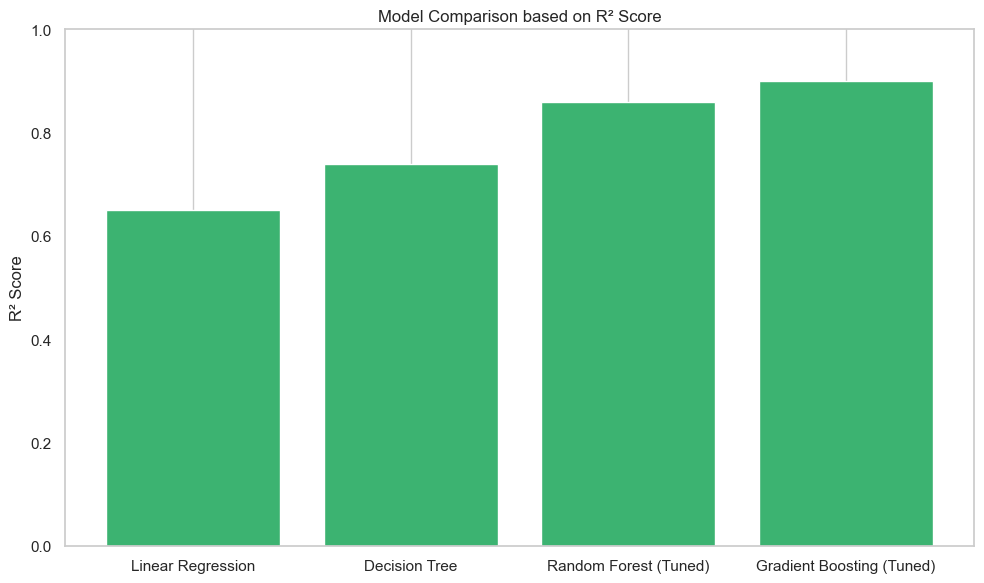

In [7]:
# MODEL COMPARISON
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color='mediumseagreen')
plt.ylabel('R² Score')
plt.title('Model Comparison based on R² Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Conclusion: Based on evaluation metrics (R², MAE, RMSE), the GRADIENT BOOSTING REGRESSOR MODEL outperformed all other models.
# It achieved the highest R² score of 0.90 along with the lowest MAE (71037.39) and RMSE (113157.40), making it the most accurate model for predicting used car prices.


In [ ]:
###### REGULARIZATION ######

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import root_mean_squared_error, r2_score

# Load the feature engineered dataset
data = pd.read_csv('processed_all_cars_data.csv')

# 1. Split into features and target
X = data.drop('Car_Price', axis=1)
y = data['Car_Price']

# One-hot encode categorical features if any remain
X = pd.get_dummies(X, drop_first=True)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Ridge Regression with Cross-Validation
ridge_cv = RidgeCV(alphas=[0.01, 0.1, 1.0, 10, 100])
ridge_cv.fit(X_train, y_train)
ridge_pred = ridge_cv.predict(X_test)

# 4. Lasso Regression with Cross-Validation
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1.0, 10], cv=5, max_iter=10000)
lasso_cv.fit(X_train, y_train)
lasso_pred = lasso_cv.predict(X_test)

# 5. Evaluation
ridge_r2 = r2_score(y_test, ridge_pred)
ridge_rmse = root_mean_squared_error(y_test, ridge_pred)

lasso_r2 = r2_score(y_test, lasso_pred)
lasso_rmse = root_mean_squared_error(y_test, lasso_pred)

# 6. Print results
print("----- Ridge Regression -----")
print("Best alpha:", ridge_cv.alpha_)
print(f"R² Score: {round(ridge_r2, 2)}")
print(f"RMSE: {round(ridge_rmse, 2)}")

print("\n----- Lasso Regression -----")
print("Best alpha:", lasso_cv.alpha_)
print(f"R² Score: {round(lasso_r2, 2)}")
print(f"RMSE: {round(lasso_rmse, 2)}")

# 7. Optional: View Lasso-selected features
lasso_coefficients = pd.Series(lasso_cv.coef_, index=X.columns)
important_features = lasso_coefficients[lasso_coefficients != 0]

print("\nLasso Selected Features (non-zero coefficients):")
print(important_features.sort_values(ascending=False))


----- Ridge Regression -----
Best alpha: 0.1
R² Score: 0.65
RMSE: 212798.55

----- Lasso Regression -----
Best alpha: 10.0
R² Score: 0.65
RMSE: 212799.36

Lasso Selected Features (non-zero coefficients):
Model_Year              57678.165925
bt                      20070.884896
Brand                    2118.301514
Car_Model                -352.279116
Insurance Validity      -3129.969182
Mileage_Category       -10600.720848
City                   -26859.692225
No_of_Owners           -40175.626975
ft                     -86651.634479
Transmission_Manual   -170941.889326
Mileage(kmpl)         -781920.385035
dtype: float64


In [ ]:
###### FINAL MODEL ######

In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# 1. Define base models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

# 2. Train base models and collect predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)

# 3. Add Tuned Gradient Boosting manually
tuned_gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)
tuned_gbr.fit(X_train, y_train)
predictions['Tuned Gradient Boosting'] = tuned_gbr.predict(X_test)

# 4. Evaluate all models
results = {}
for name, preds in predictions.items():
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, preds)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R²': r2}

# 5. Convert to DataFrame
results_df = pd.DataFrame(results).T

# 6. Add Cross-Validation scores
cv_scores = {}
for name, model in models.items():
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores[name] = np.mean(score)

# Cross-validation for tuned GBR
gbr_cv_score = cross_val_score(tuned_gbr, X_train, y_train, cv=5, scoring='r2')
cv_scores['Tuned Gradient Boosting'] = np.mean(gbr_cv_score)

# 7. Add to DataFrame and round
results_df['CV R² Score'] = pd.Series(cv_scores)
results_df = results_df.round(2)

# 8. Print final comparison
print("Model Performance Comparison:\n")
print(results_df.sort_values(by='R²', ascending=False))


Model Performance Comparison:

                               MAE           MSE       RMSE    R²  CV R² Score
Tuned Gradient Boosting   71037.39  1.280460e+10  113157.40  0.90         0.90
Random Forest             81662.03  1.844179e+10  135800.56  0.86         0.87
Decision Tree            103969.61  2.818477e+10  167883.20  0.78         0.77
Linear Regression        155594.36  4.528527e+10  212803.35  0.65         0.65
Ridge                    155499.75  4.526579e+10  212757.58  0.65         0.65
Lasso                    155593.46  4.528510e+10  212802.95  0.65         0.65


In [ ]:
###### SAVE THE FINAL MODEL - GRADIENT BOOSTING ######

In [10]:
import joblib

# Save the model to a file
joblib.dump(tuned_gbr, 'final_gradient_boosting_model.pkl')
print("Final Model is saved as 'final_gradient_boosting_model.pkl'")

Final Model is saved as 'final_gradient_boosting_model.pkl'
